# CNN with Transfer Learning
**Using ResNet-50** and Keras Functional API

---

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import PIL
import cv2
import matplotlib.pyplot as plt

from datetime import datetime

#!pip install ipdb
#import ipdb

# #------------tensorboard libraries--------------
!pip install -U tensorboard_plugin_profile

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# #------------tensorflow libraries-----------------
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# print('tensorflow version: ', tf.__version__)
# print('GPUs available: {}'.format(tf.config.list_physical_devices('GPU')))

     |████████████████████████████████| 1.1MB 7.8MB/s 


## Mount Drive and Import Data

In [2]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
project_dir = '/gdrive/My Drive/Colab Notebooks/MRI'

images_dir = project_dir + '/data/images'
%cd {project_dir} 
%pwd

/gdrive/My Drive/Colab Notebooks/MRI


'/gdrive/My Drive/Colab Notebooks/MRI'

In [4]:
import cnn_helper as hp
json_dir = project_dir + '/data'
df = hp.load_json_as_df(json_dir, 'mri-images')
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


loaded mri-images.json with shape (409, 7)



,patient-id,perspective,sequence,perspective-sequence,labels,image-number,image-name
0,TCGA120616,AX,ADC,AX-ADC,"[AX, ADC]",1,AX_ADC_Glioma_GBM_TCGA120616_1.jpg
1,TCGA120616,AX,ADC,AX-ADC,"[AX, ADC]",2,AX_ADC_Glioma_GBM_TCGA120616_2.jpg
2,TCGA764934,AX,ADC,AX-ADC,"[AX, ADC]",1,AX_ADC_Glioma_GBM_TCGA764934_1.jpg
3,TCGA764934,AX,ADC,AX-ADC,"[AX, ADC]",2,AX_ADC_Glioma_GBM_TCGA764934_2.jpg
4,TCGA766661,AX,ADC,AX-ADC,"[AX, ADC]",1,AX_ADC_Glioma_GBM_TCGA766661_1.jpg


## Data Generation

In [5]:
# select column on which to train the model
# can be perspective, sequence or perspective-sequence

x_col = 'image-name' # column in the df with full image names
y_col = 'sequence'

print("'{}' column contains {} unique classes".format(y_col,df[y_col].unique().shape[0]))

'sequence' column contains 9 unique classes


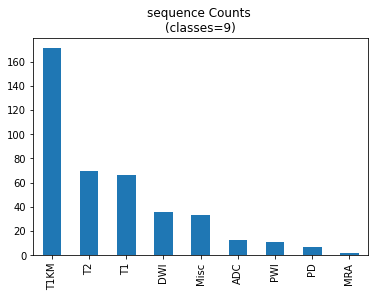

In [6]:
hp.plot_class_balances(df, y_col)

Try on T1KM, T1, T2 and DWI only first. Only use if `y_col` = `sequence`!

In [7]:
wanted = ['T1KM', 'T1', 'T2', 'DWI']
df = df.loc[df['sequence'].isin(wanted)]

The classes are highly imbalanced, need to adjust using sampling and/or class weights

Get training, validation and test sets from data

In [8]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=42)

## Data Sampling

This function performs upsampling or downsampling to balance the dataset. 

- df: dataframe to sample
- col: (string) name of column with the classes to use for samping and balancing
- n_sample_per_class: (int) max number of samples to take for each class
- replace: (bool) create duplicates to balance the classes (upsample)

In [9]:
max_train_pics = 160
max_train_val_pics = int(.2 * max_train_pics)

df_train = hp.sample_df(df_train, 
                      y_col,
                      n_sample_per_class=max_train_pics,
                      replace = True
                      )

df_test = hp.sample_df(df_test, 
                      y_col,
                      n_sample_per_class=max_train_val_pics,
                      replace = True
                      )

df_val = hp.sample_df(df_val, 
                      y_col,
                      n_sample_per_class=max_train_val_pics,
                      replace = True
                      )

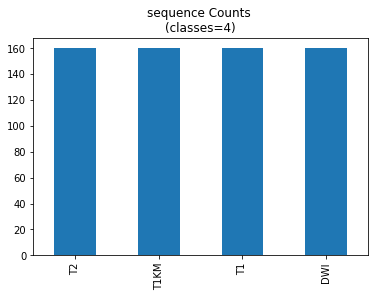

In [10]:
hp.plot_class_balances(df_train, y_col)

## Data Augmentation

Generating more data from existing images by applying transformations (e.g. rotation, shifting, zoom, etc.)

ImageDataGenerator documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [11]:
IMG_SIZE = 224
batch_size = 50

#need to pass the class names to the .flow_from_dataframe method
train_classes = df_train[y_col].unique()
train_classes = np.sort(train_classes).tolist()

datagen_train=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255,
                       rotation_range=15,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       #shear_range=0.005,
                       zoom_range=[0.9, 1.2],
                       horizontal_flip=True,
                       vertical_flip=False,
                       brightness_range=(.8,1.2),
                       fill_mode='nearest',
                      )

train_generator=datagen_train.flow_from_dataframe(
    dataframe=df_train,
    directory=images_dir,
    shuffle=True,
    x_col=x_col,
    y_col=y_col,
  # save_to_dir=savepath + '/aug_images', 
    classes=train_classes,
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

Found 640 validated image filenames belonging to 4 classes.


The data-generator will return a tensor with the images converted to tensors and the true classes for each batch of images

The batch-size that can be loaded is limited by the amount of RAM on the GPU. Higher batch sizes will train faster but setting the batch size too high will cause a memory error. (If you get an error during training try using smaller batches).

We also need a data-generator for the val-set and the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the 
model.

In [12]:
datagen_val=tf.keras.preprocessing.image.ImageDataGenerator(
                      rescale=1./255
                      )

val_generator=datagen_val.flow_from_dataframe(
    dataframe=df_val,
    directory=images_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

test_generator = datagen_val.flow_from_dataframe(
    dataframe=df_test,
    directory=images_dir, 
    x_col=x_col,
    y_col=y_col,
    class_mode='sparse',
    classes=train_classes,
    shuffle=False,
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=batch_size)

Found 128 validated image filenames belonging to 4 classes.
Found 128 validated image filenames belonging to 4 classes.


In [13]:
df_train.head()

,patient-id,perspective,sequence,perspective-sequence,labels,image-number,image-name
193,TCGA065412,AX,T2,AX-T2,"[AX, T2]",1,AX_T2_Glioma_GBM_TCGA065412_1.jpg
94,TCGA060121,AX,T1KM,AX-T1KM,"[AX, T1KM]",1,AX_T1KM_Glioma_GBM_TCGA060121_1.jpg
167,TCGA020075,AX,T2,AX-T2,"[AX, T2]",2,AX_T2_Glioma_GBM_TCGA020075_2.jpg
396,TCGA764934,SAG,T1,SAG-T1,"[SAG, T1]",1,SAG_T1_Glioma_GBM_TCGA764934_1.jpg
26,TCGA020069,AX,DWI,AX-DWI,"[AX, DWI]",1,AX_DWI_Glioma_GBM_TCGA020069_1.jpg


### View samples of augmented images

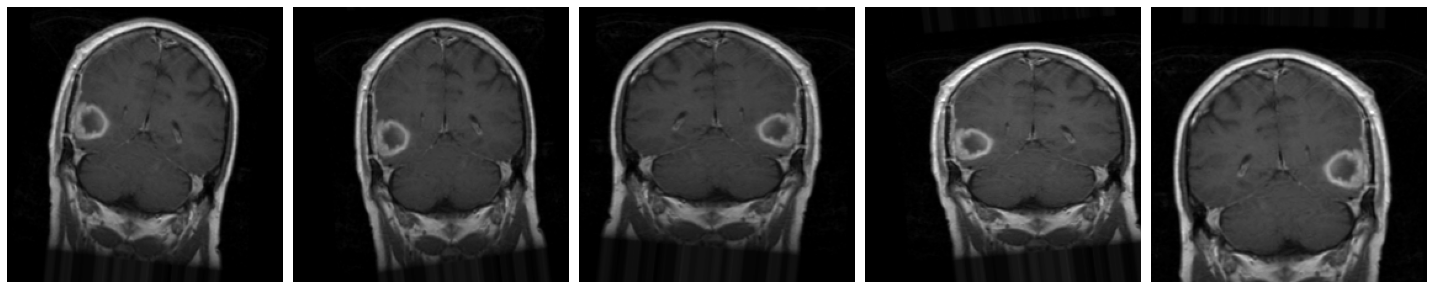

In [ ]:
# Plot 5 augmentations of 1st image in train generator
augmented_images = [train_generator[0][0][2] for i in range(5)]
hp.plot_images(augmented_images)

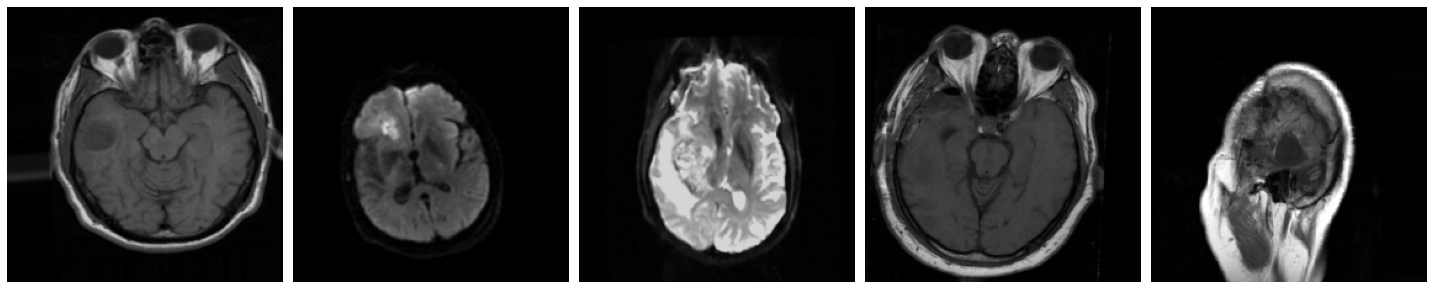

In [ ]:
# Plot 5 images from the train generator
sample_training_images, _ = next(train_generator)
hp.plot_images(sample_training_images[:5])

## Defining Step Size

In [14]:
# Since the step_size can not be in decimal places it has been rounded
steps_train = round(train_generator.n / batch_size)
steps_val = round(val_generator.n / batch_size)
steps_test = round(test_generator.n / batch_size)

In [15]:
# Get the class-numbers for all the images in the training- and test-sets
cls_train = train_generator.classes
cls_test = test_generator.classes
len(cls_train)

640

## Class Weights

To adjust for data imbalance between classes.

More information: https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7

In [16]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([1., 1., 1., 1.])

In [17]:
# class_weight has to be a dictionary format
class_weight_dict = { i : class_weight[i] for i in range(0, len(class_weight) ) }
class_weight_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

In [18]:
# getting number of classes
num_classes = len(class_weight)
num_classes

4

## Create Model Instance

To use ResNet-50 model as a base for transfer learning, we need to create a new model with the final layers suited to our number of classes.  

There are multiple ways to do this,   but we will reload the model and specifiy that we only want to load the convolutional layers. This is done  
by setting the keyword parameter `include_top=False`

In [ ]:
input_shape = (224, 224, 3)
img_inputs = tf.keras.Input(shape=input_shape)

In [ ]:
# load a new instance of the model
resnet = tf.keras.applications.resnet50.ResNet50(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet',
                                              input_tensor=img_inputs
                                                    )

last_layer = resnet.get_layer('conv5_block3_out')

94773248/94765736 [==============================] - 1s 0us/step


Using the Keras API it is very simple to create a new model. First we take the part of the base model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the base model.

In [ ]:
# load layers
ga_pooling = tf.keras.layers.GlobalAveragePooling2D()
dropout = tf.keras.layers.Dropout(0.1, seed=42)
softmax = tf.keras.layers.Dense(num_classes, activation='softmax')

# propagate resnet output
pool_img = ga_pooling(last_layer.output)
do_out = dropout(pool_img)
output = softmax(do_out)

In [ ]:
model = tf.keras.Model(inputs=img_inputs, outputs=output, name='func_resnet')
model.summary()

Model: "func_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=1e-4)
optimizer.lr.numpy()

1e-04

We have multiple categorical classes in a single column so we need to use a sparse categorical loss function

In [ ]:
loss = 'sparse_categorical_crossentropy'

In [ ]:
lst_metrics = ['sparse_categorical_accuracy']

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=lst_metrics)

## Transfer Learning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the model that may either distort its weights or cause overfitting to the new dataset.

In [ ]:
for layer in model.layers[0:-3]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "func_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________________________________________________________________________

## Create TensorBoard Callbacks

In [ ]:
logs = "data/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Uncomment when running for the fist time and change file name accordingly
logs = "data/logs/" +"functional_sequence4_augmentation_closed_180replace_epoch120_lr1e-4_dropout.1_transferlearning"

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

Early stopping gets stuck in the initial stages where the validation accuracy may be constant for 30+ epochs. Could increase `patience` to 30+ but that defeats the purpose of early stopping in my opinion. Not recommended

In [ ]:
"""
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=10,
    verbose=1,
    min_delta=0.01,
    restore_best_weights=True,
    mode='max'
)
"""

'\nearly_stopping = tf.keras.callbacks.EarlyStopping(\n    monitor="val_sparse_categorical_accuracy",\n    patience=10,\n    verbose=1,\n    min_delta=0.01,\n    restore_best_weights=True,\n    mode=\'max\'\n)\n'

## Train Model

In [ ]:
epochs = 120

In [ ]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_train,
                    class_weight=class_weight_dict,
                    validation_data=val_generator,
                    callbacks = [tboard_callback]
                    )

Epoch 1/120
14/14 [==============================] - 65s 5s/step - loss: 0.4258 - sparse_categorical_accuracy: 0.8433 - val_loss: 1.6552 - val_sparse_categorical_accuracy: 0.2292
Epoch 2/120
14/14 [==============================] - 28s 2s/step - loss: 0.0239 - sparse_categorical_accuracy: 0.9955 - val_loss: 1.6186 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/120
14/14 [==============================] - 29s 2s/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.5451 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/120
14/14 [==============================] - 29s 2s/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9970 - val_loss: 1.6938 - val_sparse_categorical_accuracy: 0.2500
Epoch 5/120
14/14 [==============================] - 29s 2s/step - loss: 0.0040 - sparse_categorical_accuracy: 0.9985 - val_loss: 1.8182 - val_sparse_categorical_accuracy: 0.2500
Epoch 6/120
14/14 [==============================] - 28s 2s/step - loss: 0.0130 - sparse_categorical_accu

## Load Saved Model

In [19]:
model = tf.keras.models.load_model('bayesian_sequence4_augment_160replace_epoch100_lre-4_closed_dropout.2_98acc.h5')

## View training logs with TensorBoard

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs

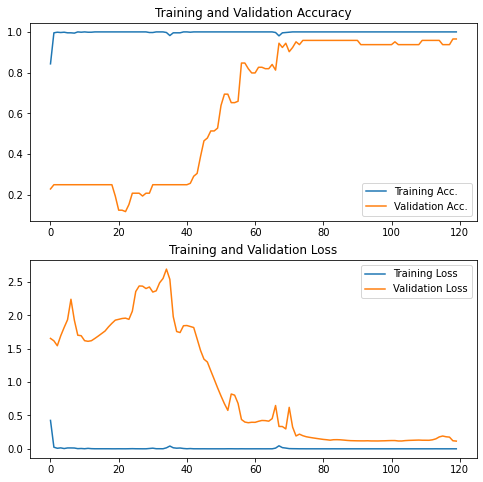

In [ ]:
hp.plot_training_history(history,lst_metrics[0])

## Model Validation

In [20]:
result = model.evaluate(test_generator, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

3/3 [==============================] - 3s 844ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9844
Test-set classification accuracy: 98.44%


In [21]:
test_history = model.predict(
                        test_generator,
                        steps=steps_test,
                        callbacks=None,
                        max_queue_size=10,
                        workers=-1,
                        use_multiprocessing=False,
                        verbose=1)

3/3 [==============================] - 1s 355ms/step


Plot confusion matrix and calculate test metrics

..................................................
showing test metrics for 128 samples
``````````````````````````````````````````````````
                         
precision_macro  0.985294
accuracy         0.984375
f1_micro         0.984375
precision_micro  0.984375
recall_macro     0.984375
recall_micro     0.984375
f1_macro         0.984360
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


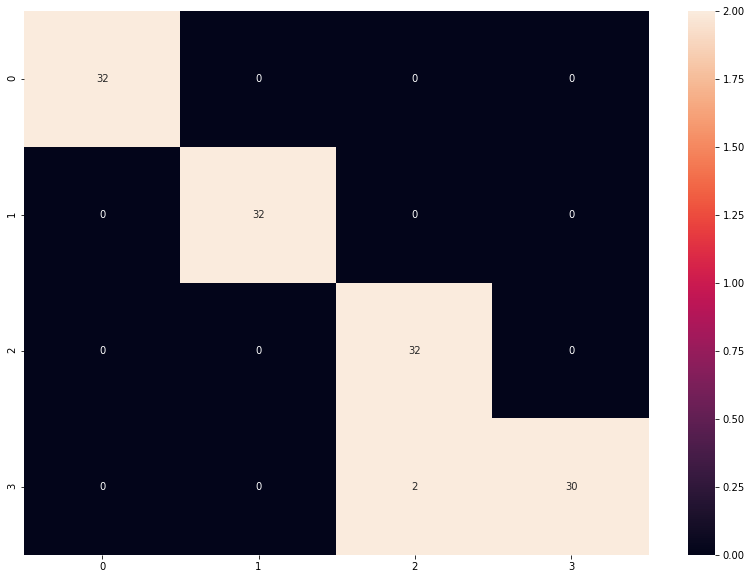

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [22]:
df_res_labels = hp.create_test_report(test_generator, test_history)

Save current model

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
model.save('sequence4_augment_180replace_epoch120_lre-4_closed_dropout.1_100acc.h5')

## View sample of images

In [23]:
test_results_df = hp.create_res_labels_df(test_generator, test_history)
test_results_df.head()

,y_true,y_pred,image_path
0,2,2,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...
1,0,0,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...
2,2,2,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...
3,0,0,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...
4,0,0,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...


In [54]:
# wrongly classified images
error_df = test_results_df.loc[(test_results_df['y_true'] != 
                                test_results_df['y_pred'])]
# class 0 correctly classified
correct_0_df = test_results_df.loc[(test_results_df['y_true'] == 0) &
                                   (test_results_df['y_pred'] == 0)]
# class 1 correctly classified
correct_1_df = test_results_df.loc[(test_results_df['y_true'] == 1) & 
                (test_results_df['y_pred'] == 1)]
# class 2 correctly classified
correct_2_df = test_results_df.loc[(test_results_df['y_true'] == 2) & 
                (test_results_df['y_pred'] == 2)]
# class 3 correctly classified
correct_3_df = test_results_df.loc[(test_results_df['y_true'] == 3) &
                                   (test_results_df['y_pred'] == 3)]
error_df

,y_true,y_pred,image_path
63,3,2,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...
96,3,2,/gdrive/My Drive/Colab Notebooks/MRI/data/imag...


View wrongly classified MRI

In [25]:
im_shape = (224, 224)

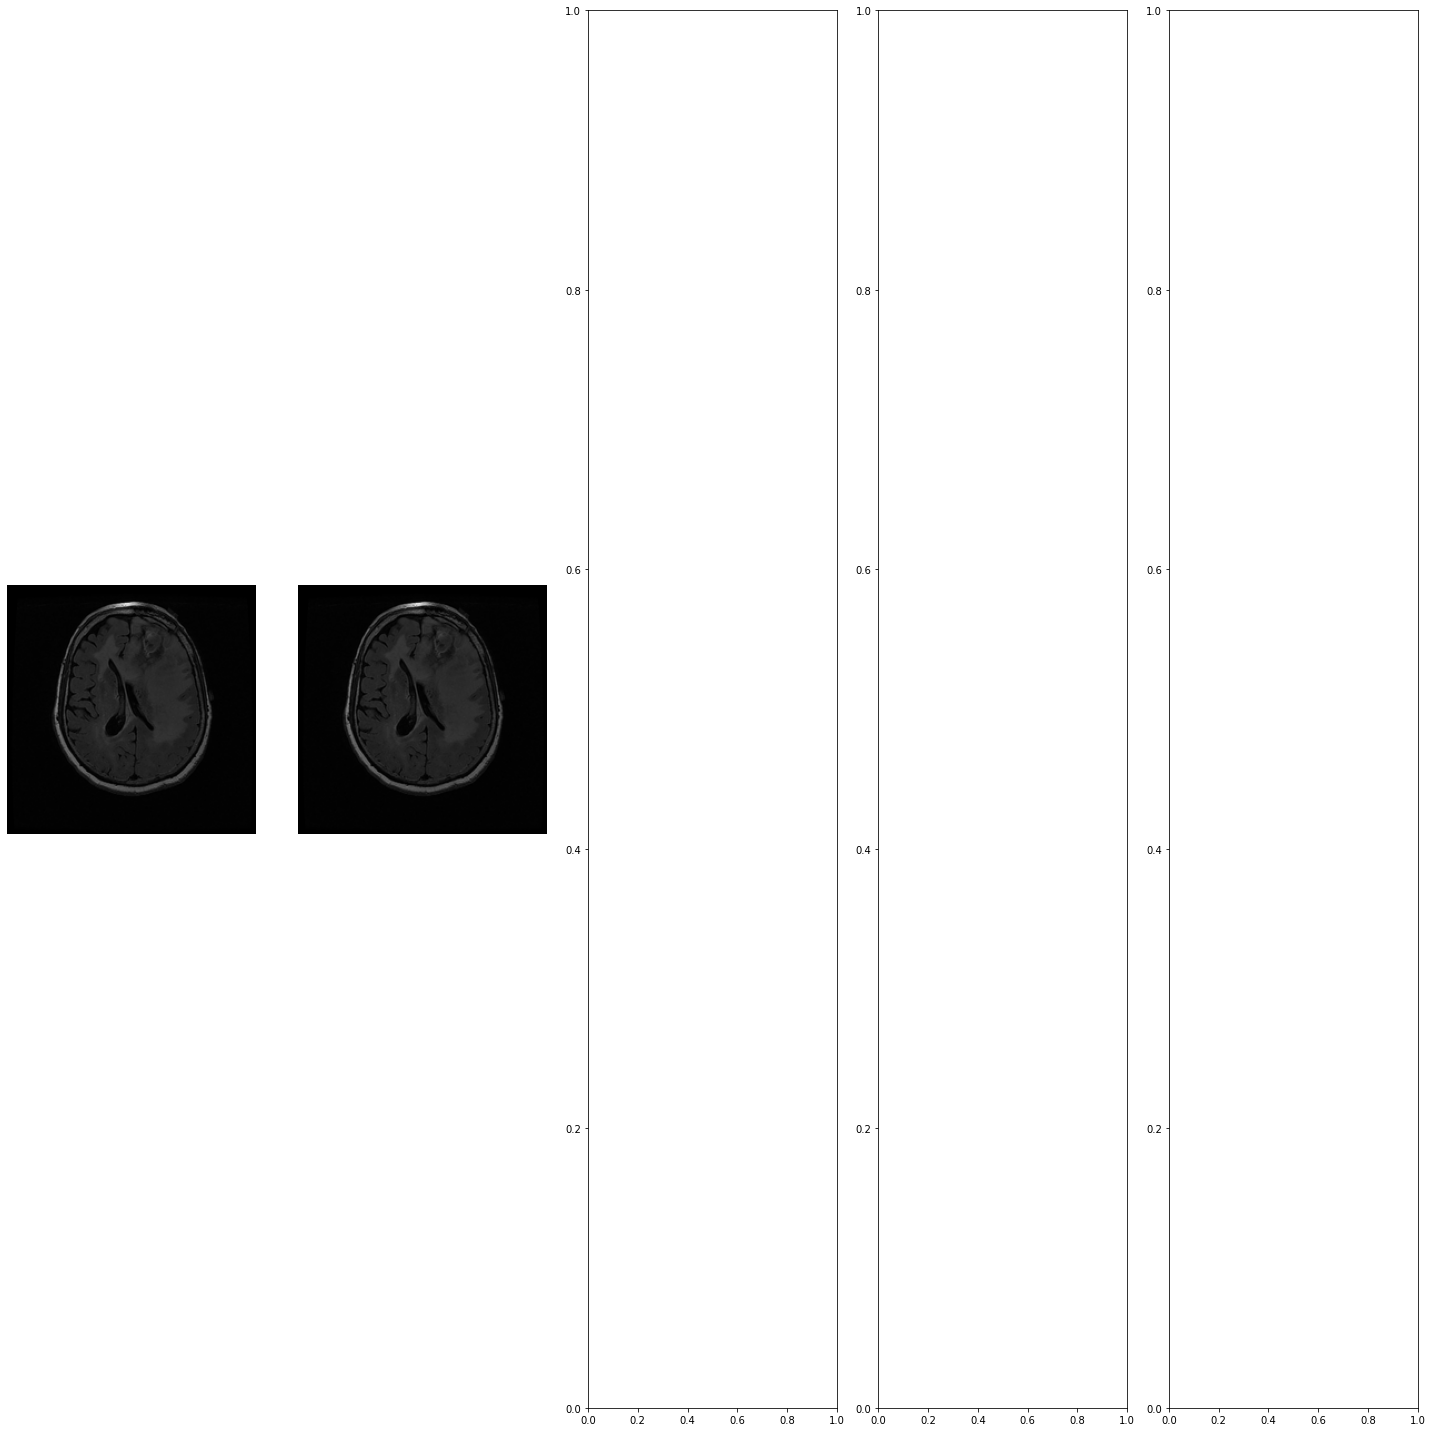

In [ ]:
img_arr0 = []
for i, path in enumerate(error_df['image_path']):
  img = PIL.Image.open(path)
  img_resized = img.resize(im_shape, PIL.Image.LANCZOS)
  img_arr0.append(np.array(img_resized))

hp.plot_images(img_arr0)

View correctly classified MRI of class 1

In [ ]:
correct_1_df.reset_index().loc[0, 'image_path']

'/gdrive/My Drive/Colab Notebooks/MRI/data/images/AX_T1_Glioma_GBM_TCGA020075_1.jpg'

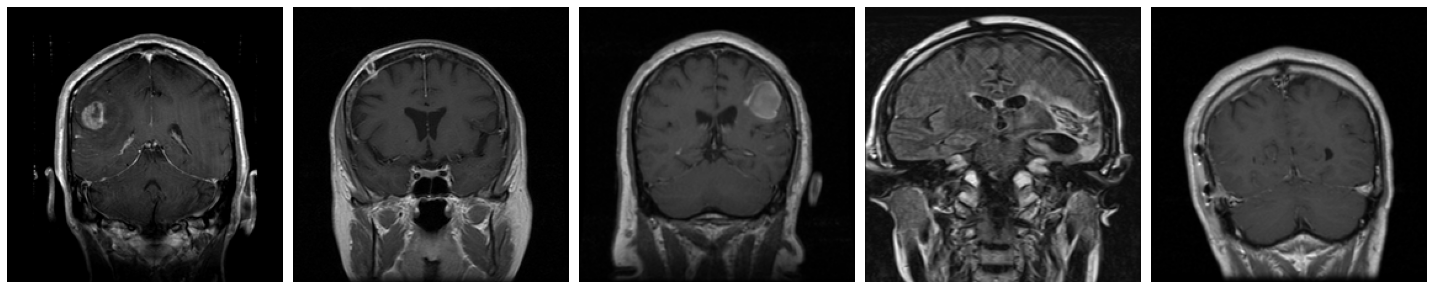

In [ ]:
img_arr1 = []
for path in correct_1_df['image_path'][:5]:
  img = PIL.Image.open(path)
  img_resized = img.resize(im_shape, PIL.Image.LANCZOS)
  img_arr1.append(np.array(img_resized))

hp.plot_images(img_arr1)

View correctly classified MRI of class 2

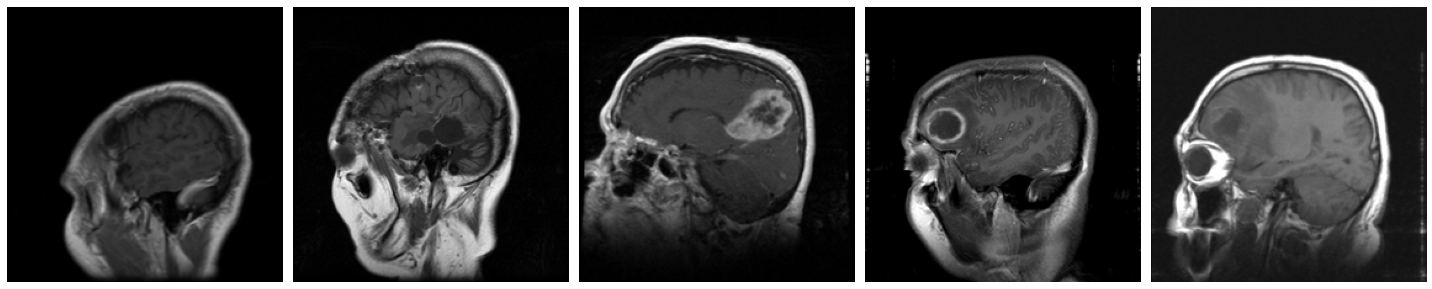

In [ ]:
img_arr2 = []
for path in correct_2_df['image_path'][:5]:
  img = PIL.Image.open(path)
  img_resized = img.resize(im_shape, PIL.Image.LANCZOS)
  img_arr2.append(np.array(img_resized))

hp.plot_images(img_arr2)

## Grad-CAM

In [26]:
from gradcam import GradCAM
#from gradcam_keras import GradCAM

In [80]:
#im_path = error_df.reset_index().loc[0, 'image_path']
im_path = correct_2_df.reset_index().loc[11, 'image_path']
#im_path = '/gdrive/My Drive/Colab Notebooks/MRI/data/images/AX_T2_Glioma_GBM_TCGA060644_1.jpg'
resized, image, orig = hp.preprocess_images(im_path)

In [81]:
# initial gradcam implementation from class
cam = GradCAM(model, layerName='conv5_block3_out')
heatmap = cam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

tf.Tensor([[3.9535359e-02 2.0168832e-01 5.4688284e-05 7.5872159e-01]], shape=(1, 4), dtype=float32)
(1, 4)


In [ ]:
# keras gradcam implementation - seems to have some bugs
#cam = GradCAM(model, layerName='conv5_block3_out')
#clf_layer_names = ['global_average_pooling2d', 'dropout', 'dense']
#heatmap = cam.compute_heatmap(im_path, im_shape, clf_layer_names)
#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
# change colourmap of heatmap and combine with original image
#(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

In [ ]:
#ipdb.runcall(cam.compute_heatmap, image)

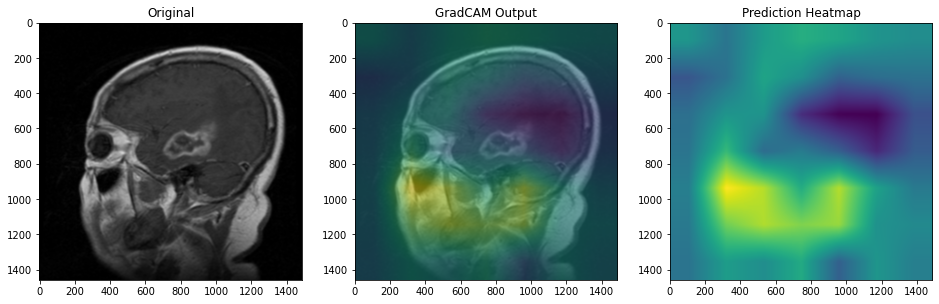

In [82]:
hp.plot_gradcam(orig, output, heatmap)